In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [68]:
reward_df_file = "ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv"
nll_df_file = "ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t2.0_humanassistant_scorednll.csv"

In [69]:
reward_df = pd.read_csv(f"data/{reward_df_file}")
nll_df = pd.read_csv(f"data/{nll_df_file}")
df = reward_df.merge(nll_df, on=["prompt", "generated_text"])
df["log_probability"] = -df["negative_log_probability"]
df = df[df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)].drop_duplicates()
print(f"Length: {len(df)}")
print(tabulate(df.head(), headers="keys", tablefmt="psql"))
print(
    tabulate(
        df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
    )
)

Length: 2000
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [70]:
num_corpuses = 100
num_samples_per_corpus = 50000

Mean Spearman: 0.3333323216044365
Mean Pearson: 0.36044722038204
Spearman: SignificanceResult(statistic=0.3229522952295229, pvalue=0.001048415559836417)
Pearson: PearsonRResult(statistic=0.3420027711473255, pvalue=0.0004964450674028042)
Binned Spearman: SignificanceResult(statistic=0.9500000000000001, pvalue=8.762523965086177e-05)
Binned Pearson: PearsonRResult(statistic=0.87529496988545, pvalue=0.001991898085633466)


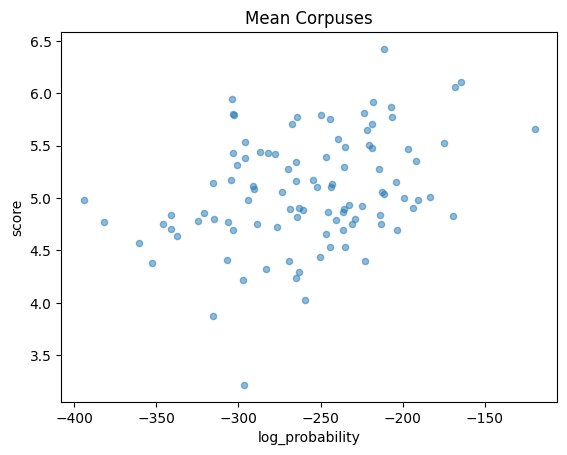

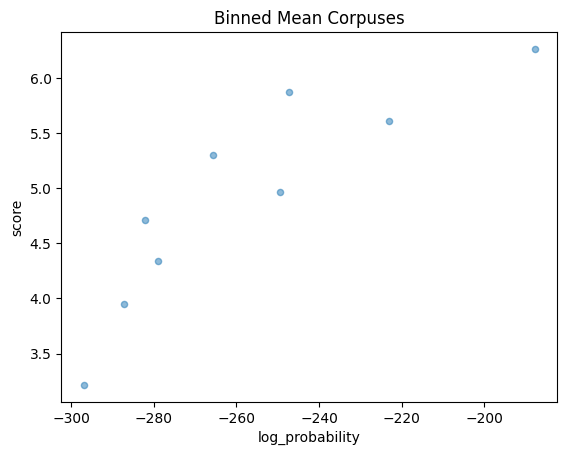

In [72]:
# Split by unique prompts
unique_prompts = df["prompt"].unique().tolist()
num_prompts_per_corpus = len(unique_prompts) // num_corpuses
np.random.shuffle(unique_prompts)
prompt_sets = {
    corpus_id: set(
        unique_prompts[
            corpus_id * num_prompts_per_corpus : corpus_id * num_prompts_per_corpus
            + num_prompts_per_corpus
        ]
    )
    for corpus_id in range(num_corpuses)
}

# Construct corpuses
corpuses = {
    corpus_id: df[df["prompt"].isin(prompts)].sample(
        n=num_samples_per_corpus, replace=True
    )
    for corpus_id, prompts in prompt_sets.items()
}
mean_corpuses_df = pd.DataFrame.from_dict({
    corpus_id: corpus[["score", "log_probability"]].mean(axis=0)
    for corpus_id, corpus in corpuses.items()
}).T

# Sample level corr
sample_spearman_corrs = {
    corpus_id: spearmanr(corpus["score"], corpus["log_probability"])
    for corpus_id, corpus in corpuses.items()
}
sample_pearson_corrs = {
    corpus_id: pearsonr(corpus["score"], corpus["log_probability"])
    for corpus_id, corpus in corpuses.items()
}
print(f"Mean Spearman: {np.mean([corr[0] for corr in sample_spearman_corrs.values()])}")
print(f"Mean Pearson: {np.mean([corr[0] for corr in sample_pearson_corrs.values()])}")

# Plot corpus level
mean_corpuses_df.plot.scatter(
    x="log_probability", y="score", alpha=0.5, title="Mean Corpuses"
)
spearman = spearmanr(mean_corpuses_df["log_probability"], mean_corpuses_df["score"])
pearson = pearsonr(mean_corpuses_df["log_probability"], mean_corpuses_df["score"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")

# Plot binned corpus level
mean_corpuses_df["bin"] = pd.cut(mean_corpuses_df["score"], bins=num_corpuses // 10)
binned_corpuses_df = mean_corpuses_df.groupby("bin", observed=True).mean()
binned_corpuses_df.plot.scatter(
    x="log_probability", y="score", alpha=0.5, title="Binned Mean Corpuses"
)
spearman = spearmanr(binned_corpuses_df["log_probability"], binned_corpuses_df["score"])
pearson = pearsonr(binned_corpuses_df["log_probability"], binned_corpuses_df["score"])
print(f"Binned Spearman: {spearman}")
print(f"Binned Pearson: {pearson}")